In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2024-07-04 23:37:36.264062: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 23:37:36.264161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 23:37:36.425859: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_dir = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train'
test_dir = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test'

In [4]:
# Define image data generator for training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define image data generator for validation data without augmentation
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Create training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Adjust based on the input size of your model
    batch_size=32,
    class_mode='categorical'
)

# Create validation data generator
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Adjust based on the input size of your model
    batch_size=32,
    class_mode='categorical'
)

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


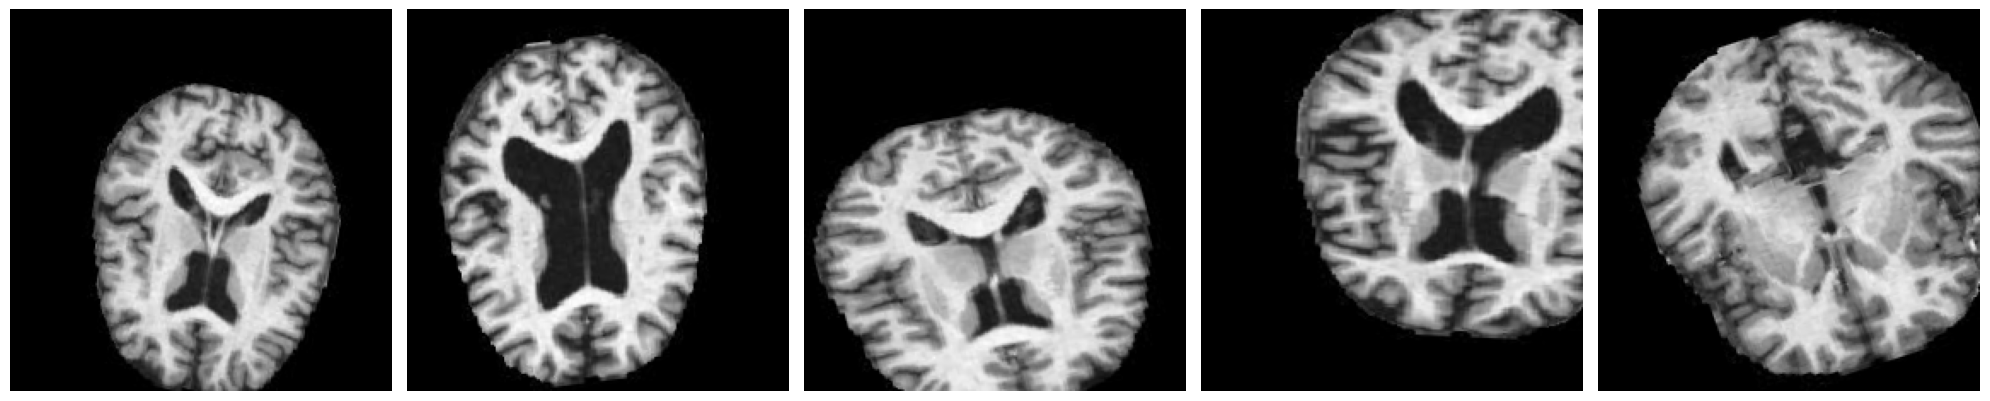

In [5]:
# Function to plot images from the generator
def plot_images(generator):
    images, labels = next(generator)
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_images(train_generator)

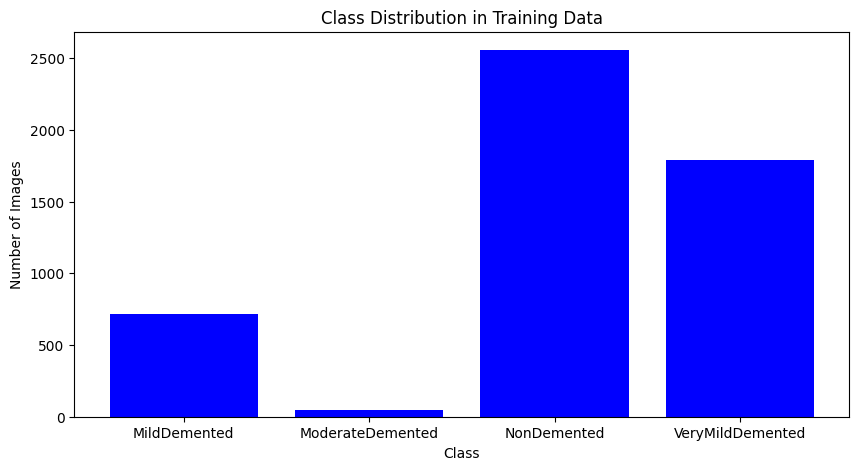

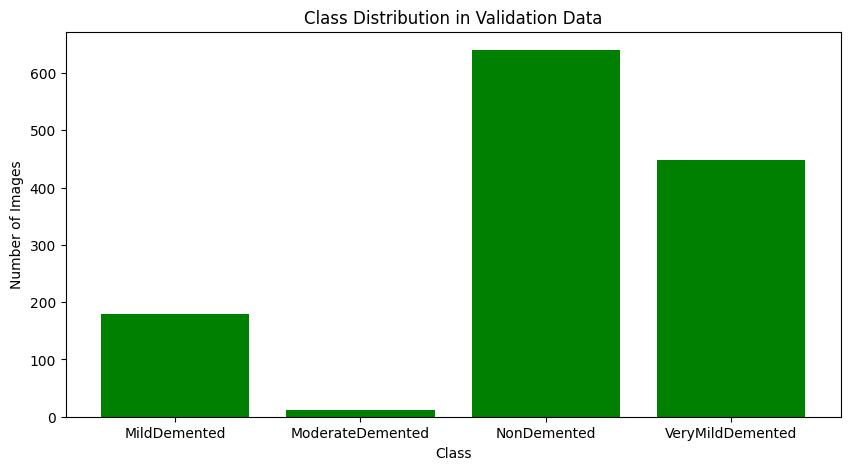

In [6]:
import matplotlib.pyplot as plt

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Plot class distribution for training data
train_class_counts = [0] * len(class_labels)
for _, labels in train_generator:
    for label in labels:
        train_class_counts[np.argmax(label)] += 1
    if sum(train_class_counts) >= train_generator.samples:
        break

plt.figure(figsize=(10, 5))
plt.bar(class_labels, train_class_counts, color='blue')
plt.title('Class Distribution in Training Data')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

# Plot class distribution for validation data
val_class_counts = [0] * len(class_labels)
for _, labels in validation_generator:
    for label in labels:
        val_class_counts[np.argmax(label)] += 1
    if sum(val_class_counts) >= validation_generator.samples:
        break

plt.figure(figsize=(10, 5))
plt.bar(class_labels, val_class_counts, color='green')
plt.title('Class Distribution in Validation Data')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

In [20]:
# Define necessary variables
initial_epochs = 10  # Placeholder value, adjust as needed
fine_tune_epochs = 20  # Placeholder value, adjust as needed

# Load the ResNet50 model, excluding the top (output) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x) 

# Create the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,638,852 (93.99 MB)

 Trainable params: 1,051,140 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [22]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

In [23]:
history = model.fit(
    train_generator,
    epochs=initial_epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

# Unfreeze top layers and recompile model for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine_tune = model.fit(
    train_generator,
    epochs=fine_tune_epochs,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.4403 - loss: 1.1665

W0000 00:00:1720138297.605480     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1720138302.484325     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


161/161 ━━━━━━━━━━━━━━━━━━━━ 71s 422ms/step - accuracy: 0.4403 - loss: 1.1663 - val_accuracy: 0.5004 - val_loss: 1.0320
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 61s 364ms/step - accuracy: 0.4592 - loss: 1.0751 - val_accuracy: 0.5004 - val_loss: 1.0285
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 61s 363ms/step - accuracy: 0.4865 - loss: 1.0558 - val_accuracy: 0.5027 - val_loss: 1.0249
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 60s 358ms/step - accuracy: 0.4984 - loss: 1.0286 - val_accuracy: 0.3956 - val_loss: 1.0529
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 60s 355ms/step - accuracy: 0.4892 - loss: 1.0371 - val_accuracy: 0.5113 - val_loss: 1.0383
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 60s 357ms/step - accuracy: 0.5016 - loss: 1.0279 - val_accuracy: 0.5246 - val_loss: 1.0251
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 63s 374ms/step - accuracy: 0.4922 - loss: 1.0309 - val_accuracy: 0.5043 - val_loss: 1.0219
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 60s 359ms/step - accuracy: 0.4984 - loss: 1.0134 - val

W0000 00:00:1720138866.783924     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.4845 - loss: 1.0389

W0000 00:00:1720138928.458033     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


161/161 ━━━━━━━━━━━━━━━━━━━━ 83s 416ms/step - accuracy: 0.4845 - loss: 1.0388 - val_accuracy: 0.5004 - val_loss: 1.0318
Epoch 2/20


W0000 00:00:1720138933.321828     128 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


161/161 ━━━━━━━━━━━━━━━━━━━━ 61s 362ms/step - accuracy: 0.4992 - loss: 1.0205 - val_accuracy: 0.5176 - val_loss: 1.0176
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 61s 363ms/step - accuracy: 0.5048 - loss: 1.0156 - val_accuracy: 0.5160 - val_loss: 0.9957
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 62s 367ms/step - accuracy: 0.5358 - loss: 0.9802 - val_accuracy: 0.5051 - val_loss: 0.9902
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 61s 365ms/step - accuracy: 0.5227 - loss: 0.9913 - val_accuracy: 0.5129 - val_loss: 0.9832
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 60s 358ms/step - accuracy: 0.5139 - loss: 0.9836 - val_accuracy: 0.5145 - val_loss: 0.9899
Epoch 7/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 61s 362ms/step - accuracy: 0.5181 - loss: 0.9817 - val_accuracy: 0.5207 - val_loss: 0.9770
Epoch 8/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 61s 363ms/step - accuracy: 0.5287 - loss: 0.9803 - val_accuracy: 0.5332 - val_loss: 0.9689
Epoch 9/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 59s 354ms/step - accuracy: 0.5324 - loss: 0.9743 - val